# Training on the Flicker HD Faces Dataset

This notebook traings a new model that is designed to specifically work on faces. It is the start of the POC work for the Heirloom Photography Repair Project (currently known as Tommy). 

## Notes

* The dataset used is the Flicker HD Faces dataset. This project was created by NVIDIA: https://github.com/NVlabs/ffhq-dataset

* The Flicker dataset is just a flat list of files. It has to be re-organized into the traditional `train`, `val` and `test` directory (with the appropriate percentages). For this notebook (but see the notes below just in case this changes) the initial split was 80, 10, 10 percent respectively. See the `build_fqhd_dataset` notebook



## TO DO

* Train with a larger Imagenet dataset

* Complete the training on the full ImageNet. Download this from Kaggle or use the max options with the current `Image-data-set-downloader`

* The Examples section at the end of the notebook generate the results to disk. Add a set of cells that can be optionally run that would instead display the images: damaged, predicted and original images.

* Train on the CelebA dataset. This is really what we will need for the mobile use case.

* Refactor some of the cells - there is too much being done in a single cell. Split. It makes it easier to read and debug.

* Sort out the 'fine tuning' aspects of this work

* 

In [1]:
import os
import gc
import datetime
import numpy as np
import pandas as pd
import cv2

from copy import deepcopy
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, LambdaCallback
from keras import backend as K
from keras.utils import Sequence
from keras_tqdm import TQDMNotebookCallback

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from IPython.display import clear_output

# Change to the project root path
if os.path.basename(os.getcwd()) != 'PConv-Keras':
    os.chdir('..')
    
from libs.pconv_model import PConvUnet
from libs.util import MaskGenerator

Using TensorFlow backend.


In [2]:
%load_ext autoreload
%autoreload 2
plt.ioff()

# Training Dataset

We will use the Flicker HD faces dataset. 

The split is 80% train, 10% validation and 10% test

In [3]:
TRAIN_DIR = r"/home/edm/work/mldata/ffhq//"
VAL_DIR = r"/home/edm/work/mldata/ffhq//"
TEST_DIR = r"/home/edm/work/mldata/ffhq//"

BATCH_SIZE = 4

# Creating train & test data generator

I think I have to change this because as I understand correctly `flow_from_directory` expects athe path where your ‘n’ classes of folders are present. My does not contain folders, it just contains images. 

Hmm what to do????

In [4]:
class AugmentingDataGenerator(ImageDataGenerator):
    def flow_from_directory(self, directory, mask_generator, *args, **kwargs):
        generator = super().flow_from_directory(directory, class_mode=None, *args, **kwargs)        
        seed = None if 'seed' not in kwargs else kwargs['seed']
        while True:
            
            # Get augmentend image samples
            ori = next(generator)

            # Get masks for each image sample            
            mask = np.stack([
                mask_generator.sample(seed)
                for _ in range(ori.shape[0])], axis=0
            )

            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori

## Create Training Generator

train_datagen = AugmentingDataGenerator(  
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1./255,
    horizontal_flip=True
    )
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, 
    MaskGenerator(512, 512, 3),
    target_size=(512, 512), 
    batch_size=BATCH_SIZE,
    classes=['train'],
)

## Create Validation Generator

val_datagen = AugmentingDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    VAL_DIR, 
    MaskGenerator(512, 512, 3), 
    target_size=(512, 512), 
    batch_size=BATCH_SIZE, 
    classes=['val'], 
    seed=42
)

## Create Testing Generator

test_datagen = AugmentingDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, 
    MaskGenerator(512, 512, 3), 
    target_size=(512, 512), 
    batch_size=BATCH_SIZE, 
    classes=['test'],
    seed=42
)

## Take a look at images and how they would look

Found 6999 images belonging to 1 classes.


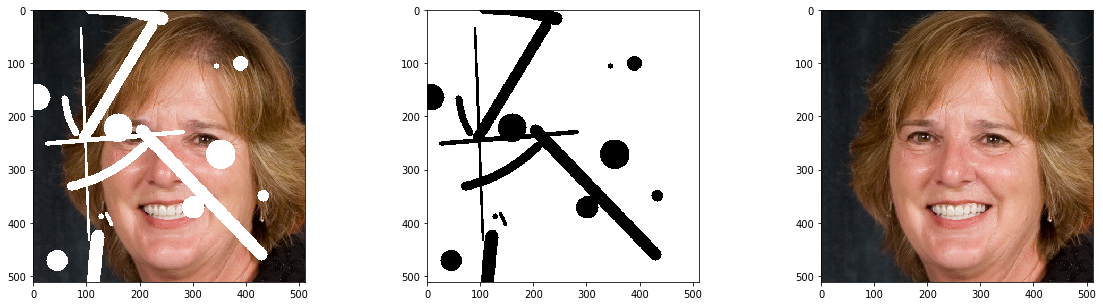

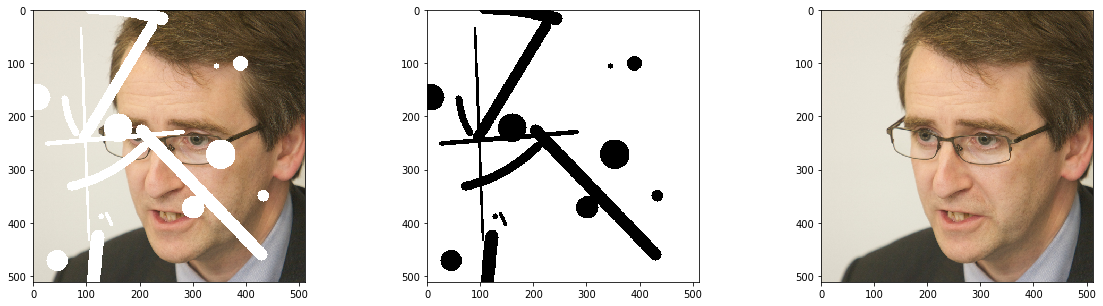

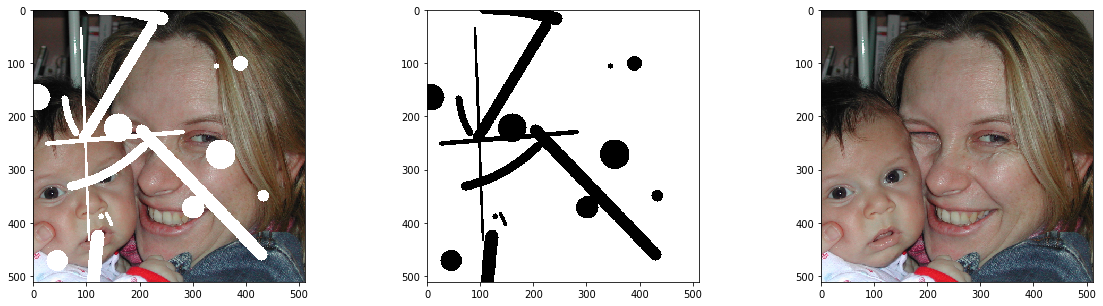

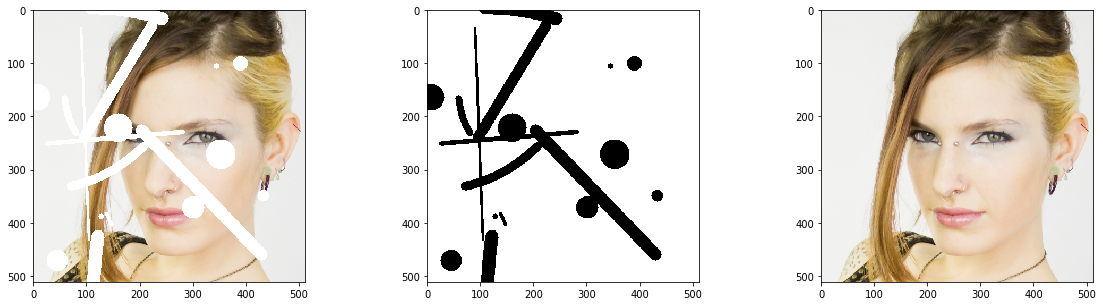

In [5]:
test_data = next(test_generator)
(masked, mask), ori = test_data

# Show side by side
for i in range(len(ori)):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(masked[i,:,:,:])
    axes[1].imshow(mask[i,:,:,:] * 1.)
    axes[2].imshow(ori[i,:,:,:])
    plt.show()

# Training on ffhq (Flicker Face Images)

In [6]:
def plot_callback(model):
    """Called at the end of each epoch, displaying our previous test images,
    as well as their masked predictions and saving them to disk"""
    
    # Get samples & Display them        
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[2].imshow(ori[i,:,:,:])
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[2].set_title('Original Image')
        
        # Line below commented out to avoid generation of large amount of 
        # local files. These are  useful for debugging but they do take up a
        # lot of space.
        
        # Replace with other code that just simply updates a window each pass.
        # To be done later.
        #plt.savefig(r'data/test_samples/img_{}_{}.png'.format(i, pred_time))
        plt.close()

## Phase 1 - with batch normalization

In [7]:
# Instantiate the model
model = PConvUnet(vgg_weights="/home/edm/work/dev/PConv-Keras/data/logs/pytorch_to_keras_vgg16.h5")

#model.load(r"/home/edm/work/dev/PConv-Keras/data/logs/imagenet_phase1_paperMasksweights.43-4.33.h5")

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
FOLDER = './data/logs/ffhq_phase1_paperMasks'

# Run training for certain amount of epochs
model.fit_generator(
    train_generator, 
    #steps_per_epoch=10000,
    steps_per_epoch=10000,
    validation_data=val_generator,
    #validation_steps=1000,
    validation_steps=100,
    #epochs=50,  
    epochs=50,
    verbose=0,
    callbacks=[
        TensorBoard(
            log_dir=FOLDER,
            write_graph=False
        ),
        ModelCheckpoint(
            FOLDER+'weights.{epoch:02d}-{loss:.2f}.h5',
            monitor='val_loss', 
            save_best_only=True, 
            save_weights_only=True
        ),
        LambdaCallback(
            on_epoch_end=lambda epoch, logs: plot_callback(model)
        ),
        TQDMNotebookCallback()
    ]
)

Instructions for updating:
Use tf.cast instead.


Found 6999 images belonging to 1 classes.
Found 55991 images belonging to 1 classes.


## Phase 2 - without batch normalization

In [10]:
# Load weights from previous run
#model = PConvUnet(vgg_weights='./data/logs/pytorch_vgg16.h5')
model = PConvUnet(vgg_weights='./data/logs/pytorch_to_keras_vgg16.h5')

model.load(
    #r"C:\Users\Mathias Felix Gruber\Documents\GitHub\PConv-Keras\data\logs\imagenet_phase1\weights.23-1.18.h5",
    # This picks off from Step1 above.
    r"/home/edm/work/dev/PConv-Keras/data/logs/ffhq_phase1_paperMasksweights.49-0.60.h5",
    train_bn=False,
    lr=0.00005
)

In [11]:
# Run training for certain amount of epochs
# Start 6/22/19 5:00 PM
model.fit_generator(
    train_generator, 
    steps_per_epoch=10000,
    validation_data=val_generator,
    validation_steps=1000,
   
    epochs=50,  
     
    verbose=0,
    callbacks=[
        TensorBoard(
            log_dir='./data/logs/ffhq_phase2',
            write_graph=False
        ),
        ModelCheckpoint(
            './data/logs/ffhq_phase2/weights.{epoch:02d}-{loss:.2f}.h5',
            monitor='val_loss', 
            save_best_only=True, 
            save_weights_only=True
        ),
        LambdaCallback(
            on_epoch_end=lambda epoch, logs: plot_callback(model)
        ),
        TQDMNotebookCallback()
    ]
)

## Phase 3 - Generating samples
Let us use the fine-tuned network to get some sample. We will save results in `data/test_samples` folder

In [12]:
# Load weights from previous run
model = PConvUnet()
model.load(
    #r"C:\Users\Mathias Felix Gruber\Documents\GitHub\PConv-Keras\data\logs\imagenet_phase2\weights.26-1.07.h5",
    #"/home/edm/work/dev/PConv-Keras/data/logs/imagenet_phase1_paperMasksweights.04-8.92.h5",
    #r"/home/edm/work/dev/PConv-Keras/data/logs/imagenet_phase1_paperMasksweights.43-4.33.h5",
    r"/home/edm/work/dev/PConv-Keras/data/logs/ffhq_phase2/weights.36-0.56.h5",
    train_bn=False,
    lr=0.00005
)

In [13]:
n = 0
for (masked, mask), ori in tqdm(test_generator):
    
    # Run predictions for this batch of images
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    
    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[0].xaxis.set_major_formatter(NullFormatter())
        axes[0].yaxis.set_major_formatter(NullFormatter())
        axes[1].xaxis.set_major_formatter(NullFormatter())
        axes[1].yaxis.set_major_formatter(NullFormatter())
                
        plt.savefig(r'data/pred_samples/img_{}_{}.png'.format(i, pred_time))
        plt.close()
        n += 1
        
    # Only create predictions for about 100 images
    #if n > 100:
    if n > 100:
        break

25it [00:24,  1.06it/s]